In [1]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt

Utility Functions

In [2]:
from pathlib import Path
from time import strftime

def get_run_logdir(root_logdir='my_logs'):
  return Path(root_logdir)/strftime('rin_%Y_%m_%d_%H_%M_%S')

run_logdir = get_run_logdir()

Loss Function testing:

In [3]:
from sklearn.datasets import make_moons
Mx , My = make_moons(n_samples = 150, noise = 0.15, random_state = 42)

(0.0, 15.0)

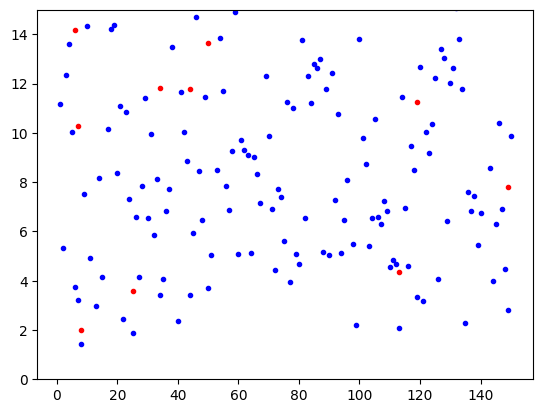

In [4]:
Mxx = np.random.randn(150)
Mxxpred = Mxx + np.random.uniform(150)*1.5
def loss(pred, true):
  loss = np.square(true) - true * pred
  loss_aux = np.sqrt(np.abs(loss))
  return loss, loss_aux
l1,l2 = loss(Mxxpred, Mxx)
for dp1,x in zip(l1, np.arange(1,151)):
  plt.plot(x,dp1 ,'r.')
for dp2,x in zip(l2, np.arange(1,151)):
  plt.plot(x,dp2,'b.')
plt.ylim(0,15)

Custom Gaussian Noise Layer

In [5]:
class GaussianNoiseReg(tf.keras.layers.Layer):
  def __init__(self, stddv, **kwargs):
    super().__init__(**kwargs)
    self.stddv = stddv

  def call(self, X, training = False):
    if training:
      noise = tf.random.normal(tf.shape(X), stddv = self.stddv)
      return X + noise

    else:
      return X

In [6]:
class RTDenseGaussianReg(tf.keras.layers.Layer):
  def __init__(self, units, stddv , activation = None , *kwargs):
    super().__init__(**kwargs)
    self.units = units
    self.stddv = stddv
    self.activation = tf.keras.activations.get(activation)

  def build(self, batch_input_shape):
    self.kernel = self.add_weight(name = 'kernel',
                                  shape = [batch_input_shape[-1], self.units],
                                  initializer = tf.keras.initializers.GlorotNormal)
    self.bias = self.add_weight(name = 'bias',
                                shape = [self.units],
                                initializer = tf.keras.initializers.Zeros)

  def call(self, X, training = False):
    if training:
      noise = tf.random.normal(tf.shape(X), stddv = self.stddv)
      if self.activation is not None:
        return self.activation(X@self.kernel+ self.bias) + noise
      else:
        return X@self.kernel + self.bias + noise
    else:
      if self.activation is not None:
        return self.activation(X@ self.kernel + self.bias)
      else:
        return X@self.kernel + self.bias

  def get_config(self):
    base_config = super().get_config()
    return {**base_config ,
            'units': self.units,
            'activation' : tf.keras.activations.serialize(self.activation)}

In [7]:
class DualIONeuralNet(tf.keras.Model):
  def __init__(self, architecture, keen_units, g_units, stddv, **kwargs):
    super().__init__(**kwargs)
    self.norm_wide = tf.keras.layers.Normalization()
    self.norm_deep = tf.keras.layers.Normalization()
    self.DeepFlow = [tf.layers.Dense(units ,
                                     activation = tf.keras.layers.LeakyReLU(alpha = 0.2),
                                     kernel_initializer = 'he-normal',
                                     kernel_regularizer = tf.keras.regularizers.L2(0.01)) for units in architecture]
    self.RTGN = RTDenseGaussianReg(g_units, stddv)
    self.WideFlow = tf.keras.layers.Dense(keen_units,
                                          activation = 'gelu',
                                          kernel_initializer = 'he_normal',
                                          kernel_regularizer =tf.keras.regularizers.L2(0.01))
    self.BatchNorm = tf.keras.layers.BatchNormalization()
    self.concat_ = tf.keras.layers.concatenate
    self.out_main = tf.keras.layers.Dense(1,
                                          activation = 'swish',
                                          kernel_initialer = 'he_normal',
                                          kernel_regularizer = tf.keras.regularizers.L2(0.01))
    self.out_aux = tf.keras.layers.Dense(1,
                                         activation = tf.keras.layers.LeakyReLU(alpha = 0.2),
                                         kernel_initializer = 'he_normal',
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))

  def call(self, inputs):
    inputs_wide , inputs_deep = inputs
    NormWide_ = self.norm_wide(inputs_wide)
    NormDeep_ = self.norm_deep(inputs_deep)
    for l_,bn_ in zip(self.DeepFlow, self.BatchNorm):
      NormDeep_ = l_(NormDeep_)
      NormDeep_ = bn_(NormDeep_)

    NormWide_ = self.RTGN(NormWide_)
    Concat = self.concat_([NormWide_, NormDeep_])
    MainOut = self.out_main(Concat)
    AuxOut = self.out_aux(NormDeep_)
    return MainOut, AuxOut

In [8]:
@tf.custom_gradient
def my_softplus(z):
  def my_softplus_gradients(grads):
    return grads*(1 - 1/(1 + tf.exp(z))) + tf.exp(z)

In [9]:
@tf.function
def train_one_epoch(model, optimizer , loss_fn, train_set):
  for X_batch , Y_batch in train_set:
    with tf.GradientTape as tape:
      y_pred = model(X_batch, Y_batch)
      main_loss = tf.reduce_mean(loss_fn(Y_batch, y_pred))
      loss = tf.add_n([main_loss] + model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

#optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
#loss_fn = tf.keras.losses.mean_squared_error
#for epoch in range(n_epochs):
#  print("\rEpoch {}/{}".format(epoch +1 , n_epochs), end = '')
#  train_one_epoch(model,optimizer , loss_fn , train_set)